# **Sentence-level Sentiment Analysis**
### **Author: Erfan Asadi - 950122680021**
This project is the final project of Data Minig Course held in Guilan University in Spring 2020. 

---





## **Project Description**
The goal of this project is to impelement Sentence level sentiment analysis on Amazon Review Data. We are going to impelement three classifier models.
1.   Naive Baysean 
2.   SVM
3. Logistic Regression

---






    

## **Contents:**


*   Libraries & Contants
*   Importing the dataset
*   Data Pre-processing
*   Data Splitting
*   Classification 
  *  Naive Baysean 
  *  SVM
  *  Logistic Regression
*   Model Evaluation
*   Model Illustration



---




### **Libraries & Contants**

**Installing Bert**

In [1]:
!pip install transformers

     |████████████████████████████████| 778kB 3.4MB/s 
     |████████████████████████████████| 890kB 17.0MB/s 
     |████████████████████████████████| 1.1MB 21.0MB/s 
     |████████████████████████████████| 3.0MB 36.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=ec69d1b9d2a37a0980eb404f5d20869f9239b70b199dc26a12f12d77b690bcf1
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
import gzip
import json

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer    
 
from transformers import BertTokenizer

%matplotlib inline
import numpy as np 
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn.metrics import precision_recall_fscore_support
from sklearn import metrics
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import BaggingClassifier

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Downloading extra files**
> Downloading stopwords...


In [3]:
# Download the nltk stopwords to customie later 
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True



---



---


## **Importing the DS**
In this step, we first load the zip file and unzip it with using gzip library and then read the json file and make a DataFrame of it using pandas library and then show the top 5 records.

**1. Download the database using WGET**

In [4]:
!wget "http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Musical_Instruments_5.json.gz"

--2020-07-19 08:29:26--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Musical_Instruments_5.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39356138 (38M) [application/octet-stream]
Saving to: ‘Musical_Instruments_5.json.gz’

Musical_Instruments 100%[===================>]  37.53M  49.5MB/s    in 0.8s    

2020-07-19 08:29:27 (49.5 MB/s) - ‘Musical_Instruments_5.json.gz’ saved [39356138/39356138]



**2. Unzipping the downloaded Dataset and put it in a pandas dataframe**

In [5]:
# Step 1 : Reading the file from system 
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

# Step 2: Convert the file to a DataFrame 
def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')


df = getDF('Musical_Instruments_5.json.gz')

In [6]:
df.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,5.0,True,"10 30, 2016",A3FO5AKVTFRCRJ,0739079891,francisco,It's good for beginners,Five Stars,1477785600,NaN,NaN,NaN
1,5.0,True,"06 30, 2016",A3UCGC1DHFMBCE,0739079891,Eb Jack Murray,I recommend this starter Ukulele kit. I has e...,Five Stars,1467244800,NaN,NaN,NaN
2,5.0,True,"05 9, 2016",A2S9SLRYLPGYZB,0739079891,Clara LaMarr,G'daughter received this for Christmas present...,Learning new songs to play regularly,1462752000,NaN,NaN,NaN
3,4.0,True,"04 10, 2016",A15RTJWPG8OKOE,0739079891,Eagle80,"According to my order history, I bought this t...",A bargain-bin good-enough ukulele that's held ...,1460246400,NaN,NaN,NaN
4,1.0,True,"02 6, 2016",A12ET1WO3OAVU7,0739079891,Amazon Customer,Please pay attention better than I did to the ...,Poor Quality product.,1454716800,NaN,NaN,NaN




---



---



## **Data Pre-processing**
In this part, we will remove the extra features and keep just two usefull feature and then will remove stopwords.

**1. Removing extra features**

In [7]:
# Removing extra features 
df = df.loc[:, ['overall','reviewText']]
df.head()

,overall,reviewText
0,5.0,It's good for beginners
1,5.0,I recommend this starter Ukulele kit. I has e...
2,5.0,G'daughter received this for Christmas present...
3,4.0,"According to my order history, I bought this t..."
4,1.0,Please pay attention better than I did to the ...


**2. Creating the customized stop words**

> In this part , we have to create our customized stop words, beacuase our task is sentiment analysis and we mustn't renove the negations.




In [8]:
#  making my custom stopwords from nltk stopwords 
negative_stopwords = ['aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'don', "don't",'hadn',
                      "hadn't", 'hasn',"hasn't", 'haven', "haven't", 'isn', "isn't", 'mightn', "mightn't", 'mustn',"mustn't",
                     'needn', "needn't", 'no', 'nor', 'not', 'shan', "shan't", 'shouldn', "shouldn't",  'wasn', "wasn't" ,'weren',
                     "weren't", "won't", 'wouldn', "wouldn't"]
new_stopwords = set(stopwords.words('english'))-{i for i in negative_stopwords}

**3. Removing the stopwords**

In [9]:
# drop nan records 
df.dropna(how="any",inplace = True)


# Re-indexing the dataframe 
df = df.reset_index().drop('index', axis = 1)

df['removedSW'] = df['reviewText'].apply(lambda x: [item for item in x.lower().split() if item not in new_stopwords])
df.head()

,overall,reviewText,removedSW
0,5.0,It's good for beginners,"[good, beginners]"
1,5.0,I recommend this starter Ukulele kit. I has e...,"[recommend, starter, ukulele, kit., everything..."
2,5.0,G'daughter received this for Christmas present...,"[g'daughter, received, christmas, present, las..."
3,4.0,"According to my order history, I bought this t...","[according, order, history,, bought, kit, towa..."
4,1.0,Please pay attention better than I did to the ...,"[please, pay, attention, better, reviews!, poo..."


**4. Removing the null records**

In [10]:
# drop records with [] removedSW
for i in range(len(df.removedSW)):
  if df.removedSW[i] == []: 
    df.drop(index=i, inplace=True)

# Re-indexing the dataframe 
df = df.reset_index().drop('index', axis = 1)


**5. Normalizing the tokens (Stemming)**

In [11]:
ps = PorterStemmer() 
  
# choose some words to be stemmed 
df['normalized'] = df['removedSW'].apply(lambda x: [ps.stem(item) for item in x])
df.head()

,overall,reviewText,removedSW,normalized
0,5.0,It's good for beginners,"[good, beginners]","[good, beginn]"
1,5.0,I recommend this starter Ukulele kit. I has e...,"[recommend, starter, ukulele, kit., everything...","[recommend, starter, ukulel, kit., everyth, ne..."
2,5.0,G'daughter received this for Christmas present...,"[g'daughter, received, christmas, present, las...","[g'daughter, receiv, christma, present, last, ..."
3,4.0,"According to my order history, I bought this t...","[according, order, history,, bought, kit, towa...","[accord, order, history,, bought, kit, toward,..."
4,1.0,Please pay attention better than I did to the ...,"[please, pay, attention, better, reviews!, poo...","[pleas, pay, attent, better, reviews!, poor, q..."


**6. Removing the repetetive words in one review.**
>Making a bag of non-repetetive word for sentiment analysis. 


In [12]:
df['preprocessed'] = df['normalized'].apply(lambda x: [i for n, i in enumerate(x) if i not in x[:n]])
df.head()

,overall,reviewText,removedSW,normalized,preprocessed
0,5.0,It's good for beginners,"[good, beginners]","[good, beginn]","[good, beginn]"
1,5.0,I recommend this starter Ukulele kit. I has e...,"[recommend, starter, ukulele, kit., everything...","[recommend, starter, ukulel, kit., everyth, ne...","[recommend, starter, ukulel, kit., everyth, ne..."
2,5.0,G'daughter received this for Christmas present...,"[g'daughter, received, christmas, present, las...","[g'daughter, receiv, christma, present, last, ...","[g'daughter, receiv, christma, present, last, ..."
3,4.0,"According to my order history, I bought this t...","[according, order, history,, bought, kit, towa...","[accord, order, history,, bought, kit, toward,...","[accord, order, history,, bought, kit, toward,..."
4,1.0,Please pay attention better than I did to the ...,"[please, pay, attention, better, reviews!, poo...","[pleas, pay, attent, better, reviews!, poor, q...","[pleas, pay, attent, better, reviews!, poor, q..."




---



---

## **Word Embedding**
In this section, we are going to map the words to vectors for making a model in next section . 

**1. Splitting  X and y**

In [13]:
# Splitting  X and y 
X = np.array(df['preprocessed'])

y = np.array(df['overall'])

Let's look at the data and its distirbution:

In [14]:
#  Know that how is our data distirbuted 
print("Strongly Negative = {}".format(len(y[y==1])/len(y) * 100)) 
print("Weakly Negative = {}".format(len(y[y==2])/len(y) * 100)) 
print("Neutral = {}".format(len(y[y==3])/len(y) * 100)) 
print("Weakly Positive = {}".format(len(y[y==4])/len(y) * 100)) 
print("Strongly Positive = {}".format(len(y[y==5])/len(y) * 100)) 

Strongly Negative = 3.2272430506613166
Weakly Negative = 3.144659526722904
Neutral = 6.927503772467258
Weakly Positive = 16.76142873820158
Strongly Positive = 69.93916491194693




In this part of code we are going to fing the average reviewText sizes to assign it to max_length.

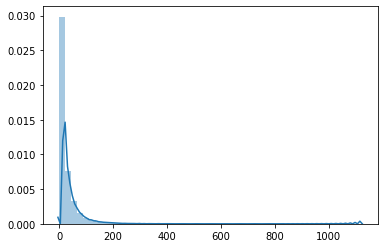

In [15]:
lens = [[np.array(review).size ] for review in X]
sns.distplot(lens)

As we see in the previous file , len = 512 seems to be good 

In [16]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
XP = np.empty((len(X),512)) 


for i in range(len(X)):
  XP[i] = tokenizer.encode_plus(
      X[i],
    max_length=512,
    add_special_tokens=True, # Add '[CLS]' and '[SEP]'
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=False,
    truncation = True,
    )['input_ids']
X = XP




---


---

## **Data Splitting**
In this part of program, we want to split the data into two parts for training and testing our models.


**Split data to train set and test set**
> We will split data into train set and test set with the test size 25 % .

In [17]:
# Splitting the data into two parts using scikitlearn 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)



---



---

# **Classification:**
1.   Naive Baysean 
2.   SVM
3. Logistic Regression





---
> ## **1. Naive Bayesian Model:**
In this section, we want to make a model using scikit learn naive baysean. 


In [18]:
#Create a Gaussian Classifier
NB_model = GaussianNB()

# Train the model using the training sets
NB_model.fit(X_train,y_train)

GaussianNB(priors=None, var_smoothing=1e-09)





---
> ## **2. SVM Model:**
In this section, we want to make a Support Vector Machine model using scikit learn library.


In [19]:
n_estimators = 10
clf = BaggingClassifier(SVC(kernel='rbf'), max_samples=1.0 / n_estimators, n_estimators=n_estimators)
clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                                     class_weight=None, coef0=0.0,
                                     decision_function_shape='ovr', degree=3,
                                     gamma='scale', kernel='rbf', max_iter=-1,
                                     probability=False, random_state=None,
                                     shrinking=True, tol=0.001, verbose=False),
                  bootstrap=True, bootstrap_features=False, max_features=1.0,
                  max_samples=0.1, n_estimators=10, n_jobs=None,
                  oob_score=False, random_state=None, verbose=0,
                  warm_start=False)



---
> ## **3. Logistic Regression Model:**
In this section, we want to make a logistic regression model using scikit learn library. 


In [20]:
#Create a Logistic Regression Classifier
LR_model = LogisticRegression()

#Train the model using the training sets
LR_model.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)



---



---

## **Model Evaluation:**
> In this section, we are going to evaluate the models which we trained using test set which we made in pervious part. We will also make a confusion matrix for each model.



---


> ### **1. Naive Baysian Model Evaluation:**

In [21]:
#Predict Output
y_pred_NB = NB_model.predict(X_test)

# making confusion matrix
NB_cm = metrics.confusion_matrix(y_test, y_pred_NB)

# calculating f1 score
NB_f1 = metrics.f1_score(y_test, y_pred_NB, average = "micro")
print("Confusion Matrix for Naive Baysean Model is :\n{}\nF1_score for Naive Baysean is {}.".format(NB_cm, NB_f1))

Confusion Matrix for Naive Baysean Model is :
[[ 1898     5     1    14     0]
 [ 1798    11     5    20     0]
 [ 3812     9     6    56     0]
 [ 9449    26    16   118     2]
 [40149    63    37   307    19]]
F1_score for Naive Baysean is 0.03548883623596963.


---
> ### **2. SVM Model Evaluation:**

In [34]:
SVM_cm = []
SVM_f1 = []

for i in range(20): 
    #Predict Output
    y_pred_SVM = clf.predict(X_test[i * 1000:i * 1000 + 1000])

    # making confusion matrix
    SVM_cm.append(metrics.confusion_matrix(y_test[i * 1000:i * 1000 + 1000], y_pred_SVM))

    # calculating f1 score
    SVM_f1.append(metrics.f1_score(y_test[i * 1000:i * 1000 + 1000], y_pred_SVM, average = "micro"))
for i in range(20): 
  if i == 0 : 
    SVM_cm_all = SVM_cm[i]
  else: 
    SVM_cm_all += SVM_cm[i] 

SVM_f1_all = 0
for i in range(20):
  SVM_f1_all += SVM_f1[i]

SVM_f1_all= SVM_f1_all/20

print("Confusion Matrix for Support Vector Machine Model is :\n{}\nF1_score for SVM is {}.".format(SVM_cm_all, SVM_f1_all))

Confusion Matrix for Support Vector Machine Model is :
[[    0     0     0     0   657]
 [    0     0     0     0   621]
 [    0     0     0     0  1407]
 [    0     0     0     0  3330]
 [    0     0     0     0 13985]]
F1_score for SVM is 0.6992499999999999.




---


> ### **3. Logistic Regression Model Evaluation:**

In [23]:
#Predict Output
y_pred_LR = LR_model.predict(X_test)

# making confusion matrix
LR_cm = metrics.confusion_matrix(y_test, y_pred_LR)

# calculating f1 score 
LR_f1 = metrics.f1_score(y_test, y_pred_LR, average = "micro")

mask = y_test == y_pred_LR
acc = len(mask[mask==True])/len(mask)

print("Confusion Matrix for Logistic Regression Model is :\n{}\nF1_score for Logistic Regression is {}.".format(LR_cm, LR_f1))


Confusion Matrix for Logistic Regression Model is :
[[    0     1     2    22  1893]
 [    1     0     1    23  1809]
 [    5     2     4    64  3808]
 [   11    12    10   115  9463]
 [   17    23    36   295 40204]]
F1_score for Logistic Regression is 0.6973763857422044.




---



---



# **Model Illustrarion:**

<BarContainer object of 3 artists>

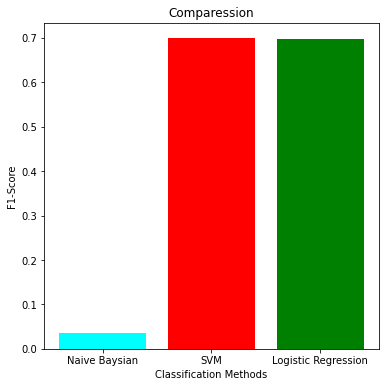

In [35]:
plt.figure(figsize=(6,6), facecolor='white')
plt.title("Comparession")
plt.xlabel("Classification Methods")
plt.ylabel("F1-Score")
plt.bar(x = ["Naive Baysian","SVM","Logistic Regression"], height = [NB_f1,SVM_f1_all,LR_f1], color = ['cyan', 'red', 'green'])